# Experiments with QUIMB
## Imports

In [2]:
import quimb as qu
from quimb import tensor as qtn

In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
import torch
import numpy as np
import scipy as sp
import cupy as cp
from tqdm.notebook import tqdm

## Code examples from quimb official site

In [21]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

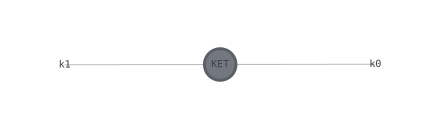

In [22]:
ket.draw()

In [23]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])
X

Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0']))

In [24]:
TN = ket.H & X & Y & bra
TN

TensorNetwork(tensors=4, indices=4)

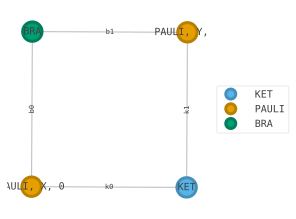

In [ ]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

In [25]:
TN ^ ...

(0.027295809086150133+0.2762115381581639j)

## Let's try to build a TTN

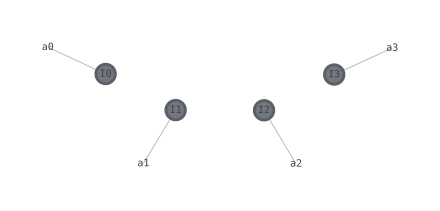

In [38]:
# generating a random MPS

ket_mps = qtn.MPS_rand_state(4, 1, site_ind_id='a{}')
ket_mps.draw()

In [39]:
ket_mps

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

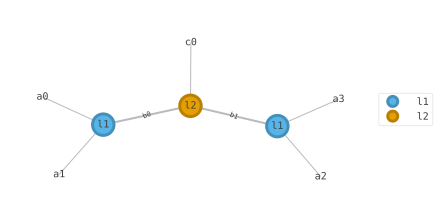

TensorNetwork(tensors=3, indices=7)

In [27]:
T1 = qtn.rand_tensor((2,2,4), inds=('a0', 'a1', 'b0'), tags=['l1'])
T2 = qtn.rand_tensor((2,2,4), inds=('a2', 'a3', 'b1'), tags=['l1'])
T3 = qtn.rand_tensor((4, 4, 2), inds=('b0', 'b1', 'c0'), tags=['l2'])

TN = T1 & T2 & T3
TN.draw(color=['l1', 'l2'], show_inds='all')
TN

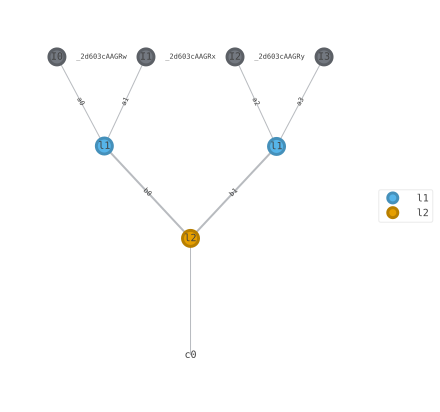

In [28]:
(TN & ket_mps).draw(color=['l1', 'l2'], show_inds='all', fix={'I{}'.format(i): (i, 5) for i in range(4)} )

In [29]:
contr = (TN & ket_mps).contract(..., backend='cupy')

In [31]:
contr.data

array([-4.49300185, -0.65061172])

# Try a TTN on MNIST
## Define TTN class

In [5]:
class TTN(qtn.TensorNetwork):
    def __init__(self, n_features, n_phys=2, n_labels=2, bond_dim=4):

        super(TTN, self).__init__()

        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")
        
        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_hlayers  = int(np.log2(n_features))-1
        self.n_labels   = n_labels
        self.bond_dim   = bond_dim


    def build(self):

        # add first tensor with special index
        if not self.n_hlayers:

            return qtn.TensorNetwork(
                [qtn.rand_phased(shape = (self.n_phys, self.n_phys, self.n_labels),
                                inds  = ['00.000', '00.001', 'label'],
                                tags  = ['l0']
                )]
            )
        else:
            tensors = [qtn.rand_phased(shape = (self.bond_dim, self.bond_dim, self.n_labels),
                                       inds  = ['00.000', '00.001', 'label'],
                                       tags  = ['l0']
                       )]


        for l in range(1, self.n_hlayers):
            
            tensors.extend([qtn.rand_phased(shape = [self.bond_dim]*3,
                                inds  = [f'{l:02}.{2*i:03}', f'{l:02}.{2*i+1:03}', f'{(l-1):02}.{i:03}'],
                                tags  = [f'l{l}']
                            ) for i in range(2**l)]
            )

        tensors.extend([qtn.rand_phased(shape = [self.n_phys]*2+[self.bond_dim],
                                inds  = [f'{self.n_hlayers:02}.{2*i:03}', f'{self.n_hlayers:02}.{2*i+1:03}', f'{(self.n_hlayers-1):02}.{i:03}'],
                                tags  = [f'l{self.n_hlayers}']
                        ) for i in range(2**self.n_hlayers)]
                        )

        self.net = qtn.TensorNetwork(tensors)
        return self.net

        

In [5]:
MyTTN = TTN(128)

In [8]:
net = MyTTN.build()
net

TensorNetwork(tensors=127, indices=255)

In [116]:
net.tensor_map.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

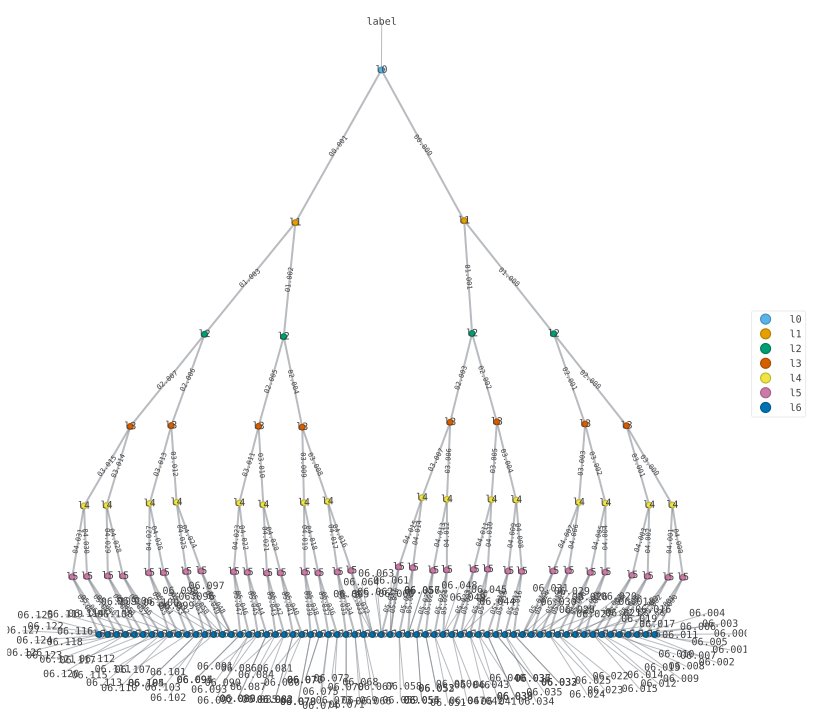

In [213]:
fig = net.draw(color=net.tags, show_inds='all', 
         fix=dict({ key : (4*i/MyTTN.n_features-1., -1.) for i, key in enumerate(list(net.tensor_map.keys())[:-MyTTN.n_features//2-1:-1])}, **{'l0':(0., 1.)}),
         return_fig=True,
         dim=2,
         figsize=(15,10)
)


In [74]:
fig.savefig('ttn.pdf')

## Let's try to train
### Preprocess

In [6]:
import torchvision as tv

def linearize(tensor: torch.Tensor):

    result = torch.clone(tensor).reshape((-1, np.prod(tensor.shape[-2:])))
    index = torch.as_tensor(range(result.shape[-1]))
    mask = index // 2 % 2 == 0

    for i in range(tensor.shape[-1]):
        result[:, (mask != i%2) & (index < (i//2+1)*2*tensor.shape[-1]) & (index >= (i//2)*2*tensor.shape[-1])]= tensor[:,i,:]

    return result

def quantize(tensor: torch.Tensor):

    cos = torch.cos(torch.pi*tensor/2)
    sin = torch.sin(torch.pi*tensor/2)

    return torch.stack([cos, sin], dim=-1)


transform = tv.transforms.Compose([tv.transforms.Resize((16, 16)), 
                                   tv.transforms.ToTensor(), 
                                   tv.transforms.Lambda(linearize), 
                                   tv.transforms.Lambda(quantize)]
            )


mnist_test  = tv.datasets.MNIST('data', download=True, train=False, transform=transform)
mnist_train = tv.datasets.MNIST('data', download=True, train=True, transform=transform)

In [7]:
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=64)

In [8]:
MyTTN = TTN(256, n_labels=10)
net = MyTTN.build()

In [9]:
net.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128, device='cuda'))
net

TensorNetwork(tensors=255, indices=511)

In [10]:
def norm(tn : qtn.TensorNetwork):
    return tn.isometrize(method="cayley")

In [9]:

class TNModel(torch.nn.Module):

    def __init__(self, myttn: TTN):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        self.myttn = myttn
        myttn.build().apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.complex128, device='cuda'))
        
        params, self.skeleton = qtn.pack(myttn.net)
        # n.b. you might want to do extra processing here to e.g. store each
        # parameter as a reshaped matrix (from left_inds -> right_inds), for 
        # some optimizers, and for some torch parametrizations
        self.torch_params = torch.nn.ParameterDict({
            # torch requires strings as keys
            str(i): torch.nn.Parameter(initial)
            for i, initial in params.items()
        })

    def forward(self, x: torch.Tensor):
        # convert back to original int key format
        params = {int(i): p for i, p in self.torch_params.items()}
        # reconstruct the TN with the new parameters
        tn = qtn.unpack(params, self.skeleton)
        results=[]

        for datum in x:
            contr = (qtn.MatrixProductState(torch.unbind(datum.unsqueeze(0), -2), site_ind_id=f'{self.myttn.n_hlayers:02}.{{:03}}') & tn) ^ ...
            results.append(contr.data)
        # isometrize and then return the energy
        return torch.stack(results)

In [10]:
model = TNModel(MyTTN)

In [13]:
x, y = next(iter(train_dl))
#qtn.MatrixProductState(torch.unbind(x[0].unsqueeze(0), -2), site_ind_id=f'{MyTTN.n_hlayers:02}.{{:03}}').draw()

In [11]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:

def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(train_dl), total=len(train_dl)//train_dl.batch_size):

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to('cuda', dtype=torch.complex128), labels.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.abs(outputs).to('cpu')

        # Compute the loss and its gradients
        loss = loss_fn(torch.nn.functional.one_hot(labels).to('cpu',dtype=torch.float64), probs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss


In [17]:
model.train()
train_one_epoch()

  0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
with torch.no_grad():
    model.eval()
    result = model(next(iter(train_dl))[0].to('cuda', dtype=torch.complex128))
result

tensor([[ 1.5270e+69+1.7324e+70j, -1.2391e+70+2.5525e+70j,
         -1.2522e+70-1.8654e+70j, -3.3734e+70-6.7137e+68j,
         -4.2885e+70+2.6510e+70j, -3.7542e+70-2.6007e+70j,
         -2.4533e+70+1.4600e+70j, -2.7915e+69+6.9435e+69j,
          2.6160e+70-6.7029e+69j, -3.8819e+69+3.0746e+70j],
        [ 2.4991e+70-6.0409e+70j, -2.8046e+70-3.4418e+70j,
         -2.9358e+70+1.6944e+70j, -2.3355e+70-4.6267e+69j,
          5.4848e+70+1.8141e+70j, -6.1475e+70+3.0860e+70j,
         -1.4726e+70+6.1191e+70j, -2.6760e+70+2.0263e+70j,
         -2.9021e+70-1.4587e+70j,  2.9887e+70-3.8308e+69j],
        [-6.7389e+72-3.0416e+72j,  2.0259e+72+1.4877e+72j,
          3.5347e+71+5.7351e+72j,  8.8043e+72+1.1592e+71j,
         -4.5983e+71-6.8644e+72j,  2.9454e+72+4.5500e+71j,
          1.2620e+72-2.6755e+72j,  5.5120e+72+8.0866e+72j,
         -1.4952e+72-8.1038e+71j,  6.6069e+72+1.1018e+72j],
        [ 1.9798e+71+3.9531e+71j,  1.6259e+71+4.1883e+71j,
         -1.6445e+71+1.2228e+70j, -2.0419e+71-1.7195e

In [51]:
states = list(torch.unbind(datum.unsqueeze(0), -2))
states[0] = states[0].squeeze(0)
states[-1] = states[-1].squeeze(0)
qtn.MatrixProductState(states, site_ind_id=f'{MyTTN.n_hlayers:02}.{{:03}}')

MatrixProductState(tensors=256, indices=511, L=256, max_bond=2)